In [4]:
import json

# Section 1: Data Preparation - Skip to Section 2 to use short_test.txt

In [41]:
def get_data(path,n=100):
    file = open(path,"r")                  
    lines = file.readlines()
    lines_subsets = lines[:n]
    article_dicts = []
    for f in lines_subsets:
        article_dicts.append(json.loads(f))
    file.close()
    return article_dicts

In [42]:
article_dicts = get_data("val.txt")  # this is 400 MB and training is 4 GB. I've extracted first 500 to play around with

In [44]:
article_dicts[0]["labels"]

In [29]:
art1 = article_dicts[0]
for k in art1:
    print(k)   # these are our features   labels is empty since this is test data

article_id
article_text
abstract_text
labels
section_names
sections


In [32]:
art1["labels"]

In [33]:
art1["sections"][0][0]#we can use the subdivisions by sections to summarize one section at a time

'the interest in anchoring phenomena and phenomena in confined nematic liquid crystals has largely been driven by their potential use in liquid crystal display devices .'

In [34]:
file = open("short_val.txt","w")
for art in article_dicts:
    json.dump(art,file)
    file.write("\n")
file.close()

# Section 2: Using Data

In [2]:
import json

In [3]:
def get_data(path,n=100):
    file = open(path,"r")                  
    lines = file.readlines()
    lines_subsets = lines[:n]
    article_dicts = []
    for f in lines_subsets:
        article_dicts.append(json.loads(f))
    file.close()
    return article_dicts

In [4]:
articles_short = get_data("short_val.txt")   #this is a list of dicts

In [5]:
articles_short[0]["sections"][0][0] #using the section level subdivisions will help us summarize one section at a time

'the interest in anchoring phenomena and phenomena in confined nematic liquid crystals has largely been driven by their potential use in liquid crystal display devices .'

In [6]:
for k in articles_short[0]:
    print(k)

article_id
article_text
abstract_text
labels
section_names
sections


In [9]:
section1 = [s.strip() for s in articles_short[10]["sections"][0]]
s = ""
str_section1 = s.join(section1)

In [10]:
str_section1

'directional couplers have been studied extensively in the context of all - optical soliton switching after the pioneering work of jensen @xcite and trillo _ et al _ @xcite .these ideas were developed and applied in fiber - optic devices which require splitting of an optical field into two coherent but physically separate parts .optical fiber couplers have been studied for their potential applications to ultra fast all optical switching processing , such as an optical switch @xcite .numerous studies , including soliton switching in dual - core optical fibers have shown excellent switching characteristics , with efficiencies around 96 % for a wide range of input energies @xcite .a review of the basic ideas and the literature can be found in saleh @xcite .recently , nonlinear directional couplers with dissimilar cores have attracted attention , as several new effects can occur in them @xcite.the study of nonliear couplers is no longer confined to the conventional silica based optical fib

# Section 3: DANCER approach

$\textbf{To give a basic overview of DANCER}$

$\textbf{1.}$ A given article has K section (s1...sk) each containing N sentences (s1k,s2k...sNk) and
an abstract (summary) A = (a1...aM)
$\textbf{2.}$ Split the abstract A into sections using the ROGUE-LCS score

$\textbf{2a.}$ For a given sentence in A, $a_i$ take each sentence in each section: $s_j^{k}$ and measure the $$R_{LCS} = |LCS|/ |s_j^k| $$

$\textbf{2b.}$ Assign $a_i$ to the section which maximized score

$\textbf{3}$ Now you have a target summary sequence $(y_1,...y_N)$ some of which are potentially empty

$\textbf{4}$ Train the summaries in parallel, with following loss function 

$$ Loss = -\sum_{t=1}^N \log P(y^t|y^1...y^{t-1},x)  $$

$\textbf{5}$ Compiling the summaries (prediction) involves autoregressively generating target summaries using beam decoding and then concatenating them


# Section 4: Modified DANCER using BERT

I'm somewhat confused about the training/fine-tuning. Given the summarizer I'm working with 
bert-extractive-summarizer I was thinking about structuring the a DANCER type algorithm as follows. Let me know if this is the correct approach.


$\textbf{1.}$ We group the sections into 3 groups, 
section 1: Intro, 
section 2: Middle Sections 
section 3: Last 

$\textbf{2.}$Apply ROGUE-LCS score to each abstract sentence to get a summary sequence. ex. of size [8,1,2]


$\textbf{3.}$ This gives us target summary proportions [a, b , c]   where 
    
    a = 8/SIZE(section1),
    
    b = 1/SIZE(section2)
    
    c = 2/SIZE(section3)


$\textbf{4.}$ Get 3 extractive summaries S1, S2, S3.  with final summary  S = S1 + S2 + S3


$\textbf{5.}$Train summaries in parallel, for input x and target summary y using something like ROGUE-1 Score :

   $$R(x,y) = |x \cap y| / |y|$$
   
$\textbf{6.}$ This gives us overall loss as follows,
    $Loss = -\sum_{(x,y)} \log R(x,y)$
    


Now if we can use fine-tuning then we should be able to tune our section summarizer to perform well on our dataset. Difficulty still remains of :

1. how to select and group sections
2. how to decide the proportion to take from each section

# Section 5: Summarizer and ROGUE Metric

In [11]:
from summarizer import Summarizer
model = Summarizer()
result = model(str_section1, ratio=0.2)  # Specified with ratio

In [12]:
print(result)

in the next sectionwe investigate two soliton pair collisions . herewe introduce the bogolibov analysis and , in the following section the variational approximation to describe modulational instability caused by the collision .comparison of the two methods winds up the paper .the results are not identical , but are compatible .


In [13]:
import numpy as np
def ROGUE_LCS(X, Y): 
    m = len(X) 
    n = len(Y) 
    #L = np.zeros((m+1,n+1))
    L = [[None]*(n + 1) for i in range(m + 1)] 
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
    return L[m][n]/n 

In [14]:
#Given an article split into sections according to section_names
#And summary sentences being the abstract split into sentences 
#We partition the summary sentences into the section level groupings using ROGUE-LCS
def match_sentences(article,summary_sentences,section_names):
    abstract_sections = [[] for i in range(len(section_names))]
    for sent in summary_sentences:
        max_precision = -10
        max_section = 0
        for i in range(len(article)):
            section_text = article[i]
            for j in range(len(section_text)):
                R = ROGUE_LCS(sent,section_text[j])
                if R > max_precision:
                    max_precision = R
                    max_section = i
        abstract_sections[max_section].append(sent)
    return abstract_sections

In [17]:
names = []
abstract_split = []
for i in range(10):
    str1 = ""
    abstract = str1.join(articles_short[i]["abstract_text"]).replace("<S>","").replace("</S>","").strip()
    summary_sentences = abstract.strip().split(".")[:-1]
    article = articles_short[i]["sections"]
    section_names = articles_short[i]["section_names"]
    abstract_sections = match_sentences(article,summary_sentences,section_names)
    names.append(section_names)
    abstract_split.append(abstract_sections)

(array([ 4.,  6., 17., 18., 26., 12.,  7.,  8.,  0.,  2.]),
 array([ 2. ,  2.9,  3.8,  4.7,  5.6,  6.5,  7.4,  8.3,  9.2, 10.1, 11. ]),
 <a list of 10 Patch objects>)

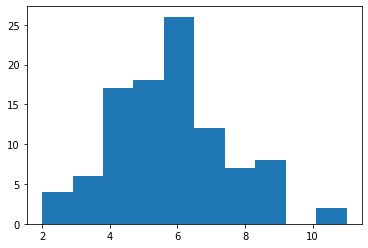

In [18]:
from matplotlib import pyplot as plt
section_lengths = [len(articles_short[i]["section_names"]) for i in range(len(articles_short))]
plt.hist(section_lengths)
#For the first 100 articles we have the following distribution of sections, with the average
#appearing to be around 6 and min/max being 3 and 11 respectively. 

In [131]:
counts = []
for v in abstract_split:
    count_split = []
    for i in v:
        count_split.append(len(i))
    counts.append(count_split)

(array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [5., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [4., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [5., 1., 2., 0., 0., 0., 0., 0., 0., 0.],
        [6., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [3., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [7., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [3., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [3., 2., 1., 2., 0., 0., 0., 0., 0., 0.]]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Lists of Patches objects>)

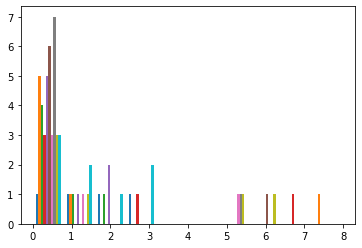

In [141]:
plt.hist(counts)
#Distribution is heavily weighted towards the 1st section